# An implementation of sequence to sequence learning for performing addition
Input: "535+61"
Output: "596"
Padding is handled by using a repeated sentinel character (space)

Fonte: https://github.com/keras-team/keras/blob/master/examples/addition_rnn.py

In [0]:
# Parameters for the model and dataset.
TRAINING_SIZE = 600000
DIGITS = 10
REVERSE = True

# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of
# int is DIGITS.
MAXLEN = DIGITS + 1 + DIGITS

# All the numbers, plus sign and space for padding.
chars = '0123456789+ '
ctable = CharacterTable(chars)

In [0]:
from __future__ import print_function
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range

Using TensorFlow backend.


In [0]:
class CharacterTable(object):
    """Given a set of characters:
    + Encode them to a one-hot integer representation
    + Decode the one-hot or integer representation to their character output
    + Decode a vector of probabilities to their character output
    """
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One-hot encode given string C.
        # Arguments
            C: string, to be encoded.
            num_rows: Number of rows in the returned one-hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        """Decode the given vector or 2D array to their character output.
        # Arguments
            x: A vector or a 2D array of probabilities or one-hot representations;
                or a vector of character indices (used with `calc_argmax=False`).
            calc_argmax: Whether to find the character index with maximum
                probability, defaults to `True`.
        """
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [0]:
questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 600000


In [0]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

Vectorization...


In [0]:
# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

In [0]:
# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

In [0]:
print('Training Data:')
print(x_train.shape)
print(y_train.shape)


Training Data:
(540000, 21, 12)
(540000, 11, 12)


In [0]:
print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

Validation Data:
(60000, 21, 12)
(60000, 11, 12)


In [0]:
# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1


In [0]:
print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
# As the decoder RNN's input, repeatedly provide with the last output of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(DIGITS + 1))
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Build model...





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 11, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 11, 128)           131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 11, 12)            1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Train the model each generation and show predictions against the validation
# dataset.
print()
print('-' * 50)

from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history = model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=100,
          validation_data=(x_val, y_val),
          callbacks=[early_stop]
          )



--------------------------------------------------
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 540000 samples, validate on 60000 samples
Epoch 1/100
540000/540000 [==============================] - 320s 593us/step - loss: 1.2586 - acc: 0.5249 - val_loss: 0.9851 - val_acc: 0.6216
Epoch 2/100
540000/540000 [==============================] - 318s 590us/step - loss: 0.8943 - acc: 0.6557 - val_loss: 0.8251 - val_acc: 0.6807
Epoch 3/100
540000/540000 [==============================] - 319s 590us/step - loss: 0.7890 - acc: 0.6958 - val_loss: 0.7499 - val_acc: 0.7109
Epoch 4/100
540000/540000 [==============================] - 316s 586us/step - loss: 0.7250 - acc: 0.7200 - val_loss: 0.6997 - val_acc: 0.7310
Epoch 5/100
540000/540000 [==============================] - 317s 586us/step - loss: 0.6501 - acc: 0.7484 - val_loss: 0.6160 - val_acc: 0.7627
Epoch 6/100
540000/540000 [==============================] - 318s 589us/step - loss: 0.

In [0]:
# Select 10 samples from the validation set at random so we can visualize
# errors.
for i in range(10):
    ind = np.random.randint(0, len(x_val))
    rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
    preds = model.predict_classes(rowx, verbose=0)
    q = ctable.decode(rowx[0])
    correct = ctable.decode(rowy[0])
    guess = ctable.decode(preds[0], calc_argmax=False)
    print('Q', q[::-1] if REVERSE else q, end=' ')
    print('T', correct, end=' ')
    if correct == guess:
        print(colors.ok + '☑' + colors.close, end=' ')
    else:
        print(colors.fail + '☒' + colors.close, end=' ')
    print(guess)

Q 842367+2              T 842369      ☑ 842369     
Q 27+9188               T 9215        ☑ 9215       
Q 480859+7828356        T 8309215     ☑ 8309215    
Q 923756785+122270      T 923879055   ☑ 923879055  
Q 7+6353                T 6360        ☑ 6360       
Q 4357+2                T 4359        ☑ 4359       
Q 820139+835524         T 1655663     ☑ 1655663    
Q 3+447814558           T 447814561   ☑ 447814561  
Q 586+49898007          T 49898593    ☑ 49898593   
Q 1897+4726             T 6623        ☑ 6623       


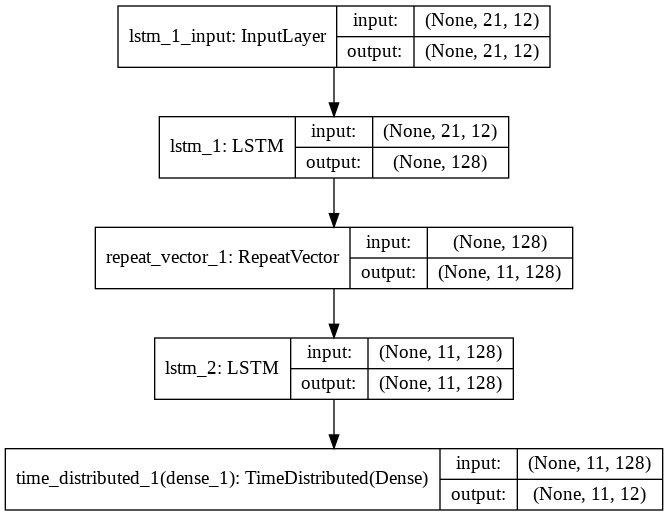

In [0]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, expand_nested=True, to_file='model.png')

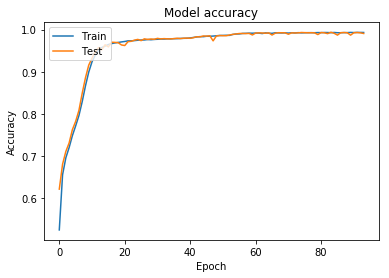

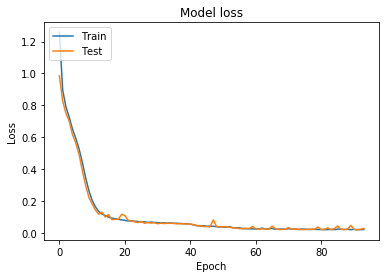

In [0]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()